In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

In [2]:
def near(a, b, rtol = 1e-5, atol = 1e-8):
    return np.abs(a-b)<(atol+rtol*np.abs(b))

In [3]:
base = np.array([[1,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0],
                 [0,1,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0],
                 [0,0,1,0,1,0,0,0],
                 [0,0,0,0,0,0,0,0],
                 [0,0,0,1,0,1,1,0],
                 [0,0,0,0,0,0,0,1]])
eye  = np.eye(2, dtype='int')

In [4]:
# Matrix that transforms the state to the right (or maybe left...)
def get_permutation(n):
    N = 2**n
    perm = np.zeros([N, N], dtype='int')
    for i in range(int(N/2)):
        perm[2*i, i] = 1
    for i in range(int(N/2)):
        perm[2*i + 1, i + int(N/2)] = 1
    return perm

In [153]:
# Transition matrix for gates on sites 1 and 2
def get_single_transition(n):
    if n < 3: 
        raise NameError('n is too small')
    if n == 3: 
        return base* 1
    else: 
        return np.kron(get_single_transition(n-1), eye)

# Transition matrix for gates on all sites with equal probability
def get_full_transition(n):
    single = get_single_transition(n)
    full   = single
#     perm   = get_permutation(n)
    perm   = np.append(range(0,2**n,2),range(1,2**n,2))
    for i in range(n-1):
        single = single[perm][:,perm]
        full += single
    return full

In [6]:
# Matrix that brings a transition matrix into irriducible form
def get_reducer(n):
    if n == 3: return np.array([[1,0,0,0,0,0,0,0],
                                [0,1,0,0,0,0,0,0],
                                [0,0,1,0,0,0,0,0],
                                [0,0,0,0,1,0,0,0],
                                [0,0,0,1,0,0,0,0],
                                [0,0,0,0,0,1,0,0],
                                [0,0,0,0,0,0,1,0],
                                [0,0,0,0,0,0,0,1]])
    
    if n == 4: return np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
                                [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
                                [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
                                [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
                                [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
                                [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
                                [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
                                [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
                                [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
                                [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
                                [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
                                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [7]:
# count the number of 1s in x
def popcount_zero(x):
    c = 0
    while x:
        x &= x - 1
        c += 1

    return c

# mask to get one subset of transition matrix
def get_mask(n, rise):
    mask = np.zeros([2**n, 2**n], dtype='bool')
    ones = n + rise
    if (ones % 2 == 0): ones = int(ones / 2)
    else: raise NameError('invalid rise for number of sites')
        
    for i, row in enumerate(mask):
        if popcount_zero(i) == ones:
            for j, val in enumerate(row):
                if popcount_zero(j) == ones:
                    mask[i,j] = True
    return mask

In [8]:
def get_steady_states(n, rise):
    transition = get_full_transition(n)/n
    a = transition[get_mask(n, rise)]
    a = a.reshape((np.sqrt(len(a)), np.sqrt(len(a))))
    
    D, V = np.linalg.eig(a)
    V = V.T
    return V[near(D, 1.0)][0]

In [126]:
def digits(number, base=2):
    assert number >= 0
    if number == 0:
        return [0]
    l = []
    while number > 0:
        l.append(number % base)
        number = number // base
    return l

def get_correlation(val,n,dist=1):
    a = np.array(digits(val))
#     print(a)
    extra = n-len(a)
    assert extra >= 0
    a = np.append(a, np.zeros(extra))
    a = 2*a-1
#     print(a)
    return (np.sum(a*np.roll(a,dist))/len(a) - (np.average(a))**2) + 1/(n-1)

def get_cors(rise, n, dist = 1):
    mask = np.zeros(2**n, dtype='bool')
    ones = n + rise
    if (ones % 2 == 0): ones = int(ones / 2)
    else: raise NameError('invalid rise for number of sites')
        
    for i, row in enumerate(mask):
        if popcount_zero(i) == ones:
            mask[i] = True
    
    states = np.arange(2**n, dtype=float)[mask]
    
    for idx, val in enumerate(states):
        states[idx] = get_correlation(val,n,dist=dist)
#         print(get_correlation(val,n), states[idx])
    return states

In [154]:
n = 4
for rise in range(-n,n+2,2):
    print("State for rise = {}".format(rise))
    state = get_steady_states(n, rise)
    print(np.real(state/np.min(state)))
    print(np.real(get_cors(rise, n)))

State for rise = -4
[ 1.]
[ 0.33333333]
State for rise = -2
[ 1.  1.  1.  1.]
[ 0.08333333  0.08333333  0.08333333  0.08333333]
State for rise = 0
[ 2.  1.  2.  2.  1.  2.]
[ 0.33333333 -0.66666667  0.33333333  0.33333333 -0.66666667  0.33333333]
State for rise = 2
[ 1.  1.  1.  1.]
[ 0.08333333  0.08333333  0.08333333  0.08333333]
State for rise = 4
[ 1.]
[ 0.33333333]


/Users/cstahl/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [156]:
rise = 0
dist = 1
for n in range(4,12,2):
    print("Correlation for length {}".format(n))
    state = get_steady_states(n, rise)
    state /= np.sum(state)
    print(np.sum(state))
    cors = get_cors(rise, n, dist=dist)
    print(np.average(cors))
    print(state@cors)

Correlation for length 4
(1+0j)
-3.70074341542e-17
(0.133333333333+0j)
Correlation for length 6
(1+0j)
1.11022302463e-17
(0.110344827586+0j)
Correlation for length 8
(1+0j)
-1.26882631386e-17
(0.117125934799+0j)
Correlation for length 10


/Users/cstahl/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1+0j)
-8.81129384623e-18
(0.116313840976+0j)


In [ ]:
slope = .25
for n in range(4,12,4):
    print("Correlation for length {}".format(n))
    state = get_steady_states(n, rise)
    state /= np.sum(state)
    print(np.sum(state))
    cors = get_cors(rise, n)
    print(np.average(cors))
    print(state@cors)

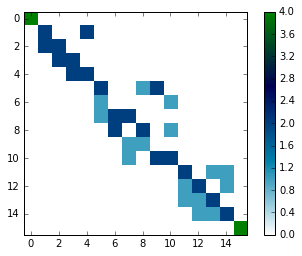

In [10]:
n = 4
red = get_reducer(n)
plt.imshow(red.T @ get_full_transition(n) @ red, interpolation='nearest', cmap=plt.cm.ocean_r)
plt.colorbar()
plt.show()

In [151]:
n = 8
a = np.append(range(0,n,2),range(1,n,2))
print(a)

[0 2 4 6 1 3 5 7]


In [152]:
n = 3
single = get_single_transition(n)
# print(single)
full   = single
#     perm   = get_permutation(n)
perm   = np.append(range(0,2**n,2),range(1,2**n,2))
# print(perm)
for i in range(n-1):
    single = single[perm][:,perm]
#     print(single)
    full += single
print(full)

[[3 0 0 0 0 0 0 0]
 [0 1 0 0 2 0 0 0]
 [0 2 1 0 0 0 0 0]
 [0 0 0 1 0 1 1 0]
 [0 0 2 0 1 0 0 0]
 [0 0 0 1 0 1 1 0]
 [0 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 3]]


In [49]:
digits(194,base=10)

[4, 9, 1]

In [159]:
np.real((1+1j,2))

array([ 1.,  2.])

In [164]:
a = np.array([])
a = np.append(a,(1,2))
a = np.append(a,(1,2),axis=1)

IndexError: axis 1 out of bounds [0, 1)